In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import os
import shutil
import random
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger, Callback
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Loading Datasets From Previous Notebook

In [ ]:
# loading dataset
!wget -O plantvillage.zip https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/d5652a28-c1d8-4b76-97f3-72fb80f94efc/file_downloaded
!unzip plantvillage.zip

Streaming output truncated to the last 5000 lines.
  inflating: Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (132).JPG  
  inflating: Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1320).JPG  
  inflating: Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1321).JPG  
  inflating: Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1322).JPG  
  inflating: Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1323).JPG  
  inflating: Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1324).JPG  
  inflating: Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1325).JPG  
  inflating: Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/i

In [ ]:
# set dataset directory
data_dir = 'Plant_leave_diseases_dataset_without_augmentation'
# directory for dataset splits
new_data_dir = 'PlantVillage'
os.makedirs(new_data_dir, exist_ok=True)

# set random seed
seed = 49
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# load split indicies
train_paths = np.load('train_indices.npy')
val_paths = np.load('val_indices.npy')
test_paths = np.load('test_indices.npy')

def copy_images(image_list, subset_name, source_dir, destination_dir):
    for image_path in image_list:
        class_name = os.path.basename(os.path.dirname(image_path))
        dest_dir = os.path.join(destination_dir, subset_name, class_name)
        os.makedirs(dest_dir, exist_ok=True)

        dest_path = os.path.join(dest_dir, os.path.basename(image_path))
        shutil.copy2(image_path, dest_path)

# copy images to new directory
copy_images(train_paths, 'train', data_dir, new_data_dir)
copy_images(val_paths, 'val', data_dir, new_data_dir)
copy_images(test_paths, 'test', data_dir, new_data_dir)

# DenseNet Model

In [ ]:
# load model
densenet = keras.applications.DenseNet201(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    name="densenet201",
)

# freeze model
densenet.trainable = False

# print model summary
densenet.summary()

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "densenet201"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, None, None, 3)  │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, None, None, 64) │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, None, None, 64) │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, None, None, 64) │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, None, None, 64) │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, None, None, 64) │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, None, None, 64) │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, None, None, 64) │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, None, None,     │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, None, None,     │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, None, None,     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, None, None, 32) │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, None, None, 96) │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 18,321,984 (69.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 18,321,984 (69.89 MB)

In [ ]:
# test inference with dummy batch
dummy_batch = tf.random.normal((1, 224, 224, 3))
output = densenet(dummy_batch)

print(output.shape)

(1, 7, 7, 1920)


# Model

In [ ]:
img_height = 224
img_width = 224

# get num_classes from dataset
num_classes = 39

# define model
model = tf.keras.Sequential([
    layers.InputLayer(input_shape=(None, None, 3)),

    # normalization layer
    layers.Normalization(mean=[0.485, 0.456, 0.406],
                         variance=[0.229**2, 0.224**2, 0.225**2]),

    densenet,

    layers.GlobalAveragePooling2D(),

    layers.Activation('relu'),

    layers.Dense(num_classes, activation='softmax')
], name='DenseNet201_Transfer_PlantVillage')

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "DenseNet201_Transfer_PlantVillage"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization (Normalization)        │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet201 (Functional)             │ (None, None, None, 1920)    │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1920)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 1920)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 39)                  │          74,919 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,396,903 (70.18 MB)

 Trainable params: 74,919 (292.65 KB)

 Non-trainable params: 18,321,984 (69.89 MB)

# Training

In [ ]:
# custom callback
class SaveEveryXEpochs(Callback):
    def __init__(self, save_every, save_path):
        super(SaveEveryXEpochs, self).__init__()
        self.save_every = save_every
        self.save_path = save_path

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_every == 0:
            filepath = os.path.join(self.save_path, f'model_epoch_{epoch + 1}.keras')
            self.model.save(filepath)
            print(f'\nModel saved at epoch {epoch + 1} to {filepath}')


# callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

checkpoint_dir = 'model_checkpoints'

checkpoint = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'best_model.keras'),
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

save_every_x_epochs = SaveEveryXEpochs(
    save_every=5,
    save_path=checkpoint_dir
)

callbacks = [
    early_stopping,
    reduce_lr,
    checkpoint,
    save_every_x_epochs
]


In [ ]:
# batching
batch_size = 512

# class weights
class_weights = np.load('class_weights.npy', allow_pickle=True).item()

# data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


train_ds = train_datagen.flow_from_directory(
    os.path.join(new_data_dir, 'train'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    seed=seed
)

val_ds = val_datagen.flow_from_directory(
    os.path.join(new_data_dir, 'val'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_ds = test_datagen.flow_from_directory(
    os.path.join(new_data_dir, 'test'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 38813 images belonging to 39 classes.
Found 8317 images belonging to 39 classes.
Found 8318 images belonging to 39 classes.


In [15]:
history = model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    #class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6754 - loss: 1.4793
Epoch 1: val_accuracy improved from -inf to 0.81375, saving model to model_checkpoints/best_model.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 730s 9s/step - accuracy: 0.6762 - loss: 1.4763 - val_accuracy: 0.8138 - val_loss: 0.8980 - learning_rate: 0.0010
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8549 - loss: 0.8006
Epoch 2: val_accuracy improved from 0.81375 to 0.88385, saving model to model_checkpoints/best_model.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 539s 6s/step - accuracy: 0.8551 - loss: 0.7995 - val_accuracy: 0.8839 - val_loss: 0.5979 - learning_rate: 0.0010
Epoch 3/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9042 - loss: 0.5387
Epoch 3: val_accuracy improved from 0.88385 to 0.90525, saving model to model_checkpoints/best_model.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 523s 6s/step - accuracy: 0.9043 - loss: 0.5382 - val_accuracy: 0.9053 - val_loss: 0.4589 - learning_rate: 0.0010
Epoch 4/20
76

KeyboardInterrupt: 

# Evaluation

In [19]:
# evaluate on test set
test_loss, test_acc = model.evaluate(test_ds)
print(f'Test accuracy: {test_acc}, Test Loss: {test_loss}')

17/17 ━━━━━━━━━━━━━━━━━━━━ 67s 4s/step - accuracy: 0.9507 - loss: 0.1916
Test accuracy: 0.9495071172714233, Test Loss: 0.19143514335155487


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step


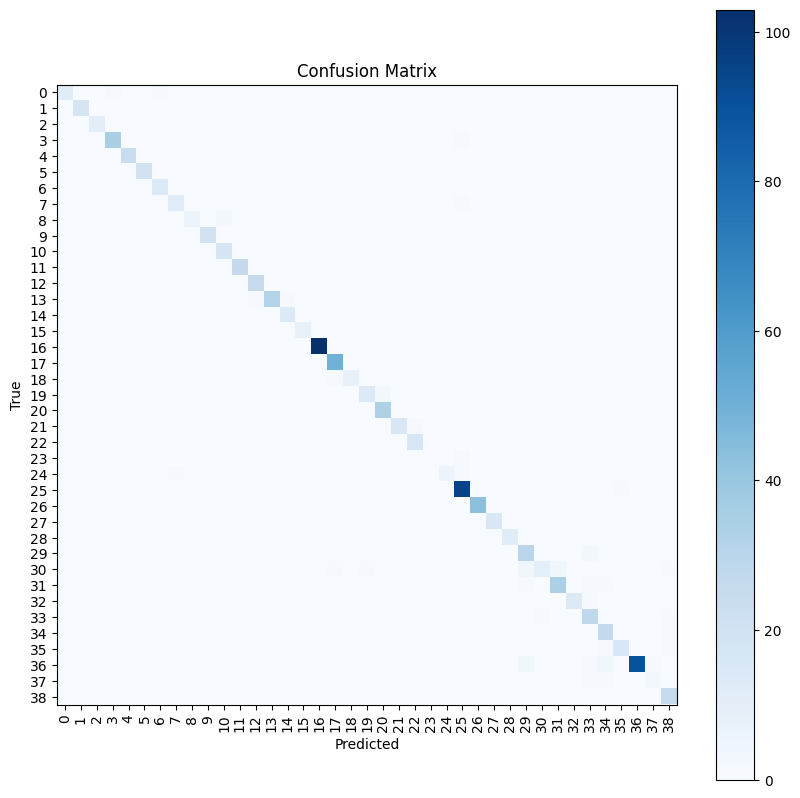

In [21]:
# plot confusion matrix
y_true = []
y_pred = []

for images, labels in test_ds:
    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(np.argmax(model.predict(images), axis=1))

    if len(y_true) >= 1000:
        break

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(39), rotation=90)
plt.yticks(np.arange(39))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [23]:
# plot ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(39):
    y_true = []
    y_pred = []

    for images, labels in test_ds:
        y_true.extend(np.argmax(labels, axis=1))
        y_pred.extend(model.predict(images)[:, i])
        if len(y_true) >= 1000:
            break

    fpr[i], tpr[i], _ = roc_curve(y_true, y_pred)
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve for class {i} (area = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step


ValueError: multiclass format is not supported